# This script uses a Neural Network to predict number of tornado fatalities given EF rating, number of Injuries, Length (miles), and Width (yds)

In [1]:
!pip3 install ann_visualizer
!pip install graphviz

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy

### 1. Import & Inspect the Data

In [3]:
# # Connect to Google Drive
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [4]:
# # Loading data
# tornado_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/Final_Project/2008-2020_tornadoes_EF_cleaned.csv")
# tornado_df

In [5]:
# Apache Spark Set Up

import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [6]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Tornadoes").getOrCreate()

In [7]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://group-2-project-tornadoes.s3.amazonaws.com/2008-2020_tornadoes_EF_cleaned_db.csv"
spark.sparkContext.addFile(url)
tornado = spark.read.csv(SparkFiles.get("2008-2020_tornadoes_EF_cleaned_db.csv"), sep=",", header=True)

# Show DataFrame
tornado.show()

+-------+---------+----+-----+---+----------------+-------+---------+---------+---------+-------+-------+---+--------+----------+-------+---------+------+-----+
|Torn_ID|County_ID|Year|Month|Day|       Timestamp|ST_FIPS|CNTY_FIPS|Start_Lat|Start_Lon|End_Lat|End_Lon| EF|Injuries|Fatalities|   Loss|Crop_Loss|Length|Width|
+-------+---------+----+-----+---+----------------+-------+---------+---------+---------+-------+-------+---+--------+----------+-------+---------+------+-----+
|      1|    35049|2008|   10| 11|10/11/2008 18:33|     35|       49|    35.15|  -105.94|      0|      0|  0|       0|         0|  12000|     null|  0.02|   10|
|      2|    20181|2008|   10| 11|10/11/2008 21:54|     20|      181|    39.33|  -101.55|      0|      0|  0|       0|         0|   null|     null|  0.25|   10|
|      3|    13039|2008|   10| 24|10/24/2008 16:55|     13|       39|    31.02|   -81.81|      0|      0|  0|       0|         0|   1000|     null|  0.25|   25|
|      4|     5113|2008|   10|  6|

In [8]:
# Convert spark object to pandas dataframe
tornado_df = tornado.toPandas()
tornado_df

,Torn_ID,County_ID,Year,Month,Day,Timestamp,ST_FIPS,CNTY_FIPS,Start_Lat,Start_Lon,End_Lat,End_Lon,EF,Injuries,Fatalities,Loss,Crop_Loss,Length,Width
0,1,35049,2008,10,11,10/11/2008 18:33,35,49,35.15,-105.94,0,0,0,0,0,12000,None,0.02,10
1,2,20181,2008,10,11,10/11/2008 21:54,20,181,39.33,-101.55,0,0,0,0,0,None,None,0.25,10
2,3,13039,2008,10,24,10/24/2008 16:55,13,39,31.02,-81.81,0,0,0,0,0,1000,None,0.25,25
3,4,5113,2008,10,6,10/6/2008 13:46,5,113,34.58,-94.15,34.63,-94.12,1,0,0,75000,None,3.41,250
4,5,48067,2008,10,6,10/6/2008 16:05,48,67,33.07,-94.1,33.09,-94.08,0,0,0,75000,None,1.5,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15886,15887,47095,2020,9,1,9/1/2020 16:24,47,95,36.329,-89.4981,36.3517,-89.4729,0,0,0,None,2000,2.1,50
15887,15888,24003,2020,9,3,9/3/2020 15:57,24,3,38.948,-76.5695,38.9233,-76.4615,0,0,0,1250000,None,6.05,100
15888,15889,6039,2020,9,5,9/5/2020 16:17,6,39,37.35,-119.34,37.5218,-119.3056,2,0,0,None,None,12.02,50
15889,15890,6019,2020,9,5,9/5/2020 18:29,6,19,37.25,-119.2,37.2598,-119.1838,1,0,0,None,None,1.12,25


In [9]:
# Check data types
tornado_df.dtypes

Torn_ID       object
County_ID     object
Year          object
Month         object
Day           object
Timestamp     object
ST_FIPS       object
CNTY_FIPS     object
Start_Lat     object
Start_Lon     object
End_Lat       object
End_Lon       object
EF            object
Injuries      object
Fatalities    object
Loss          object
Crop_Loss     object
Length        object
Width         object
dtype: object

In [10]:
# Convert timestamp to datetime
tornado_df['Timestamp']= pd.to_datetime(tornado_df['Timestamp'])

# Convert all strings to numeric
cols=[i for i in tornado_df.columns if i not in ["Timestamp"]]
for col in cols:
    tornado_df[col]=pd.to_numeric(tornado_df[col])

# check dtypes
tornado_df.dtypes

Torn_ID                int64
County_ID              int64
Year                   int64
Month                  int64
Day                    int64
Timestamp     datetime64[ns]
ST_FIPS                int64
CNTY_FIPS              int64
Start_Lat            float64
Start_Lon            float64
End_Lat              float64
End_Lon              float64
EF                     int64
Injuries               int64
Fatalities             int64
Loss                 float64
Crop_Loss            float64
Length               float64
Width                  int64
dtype: object

In [11]:
tornado_df.columns

Index(['Torn_ID', 'County_ID', 'Year', 'Month', 'Day', 'Timestamp', 'ST_FIPS',
       'CNTY_FIPS', 'Start_Lat', 'Start_Lon', 'End_Lat', 'End_Lon', 'EF',
       'Injuries', 'Fatalities', 'Loss', 'Crop_Loss', 'Length', 'Width'],
      dtype='object')

In [12]:
# drop na columns
tornado_df = tornado_df.dropna()

### 1. Define input data (X) and output data (y)

In [13]:
X = tornado_df.copy()
X = X.drop(['Torn_ID','County_ID','Year', 'Month', 'Day', 'Timestamp','ST_FIPS','CNTY_FIPS','Start_Lat','Start_Lon','End_Lat', 'End_Lon','Injuries','Fatalities','Crop_Loss','EF'], axis=1)
X

,Loss,Length,Width
22,510000.0,8.13,200
28,500000.0,4.09,150
29,1000000.0,8.19,100
73,350000.0,10.59,500
81,20000.0,3.14,250
...,...,...,...
15764,20000.0,1.26,50
15785,35000.0,0.26,50
15786,45000.0,2.17,100
15838,150000.0,2.58,100


In [14]:
y = tornado_df["Fatalities"].ravel()
y[:10]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### 2. Splitting into Train and Test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =78)

### 3. Scale the input data (X)

In [16]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### 4. Define Deep Learning Model

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X.columns)
hidden_nodes_layer1 = 3
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh") )

# Second hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh") )

# Output layer
nn.add( tf.keras.layers.Dense(units=1, activation="sigmoid") )

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


### 5. Compile & Train the Model

In [18]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [19]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period = 5)

In [20]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,validation_split=0.33, epochs=200,callbacks=[cp_callback])

Epoch 1/200
11/11 [==============================] - 1s 22ms/step - loss: 4.7697 - accuracy: 0.2804 - val_loss: 0.6297 - val_accuracy: 0.3019
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 4.7520 - accuracy: 0.3084 - val_loss: 0.6193 - val_accuracy: 0.3145
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 4.7368 - accuracy: 0.3769 - val_loss: 0.6101 - val_accuracy: 0.3836
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 4.7238 - accuracy: 0.4735 - val_loss: 0.6025 - val_accuracy: 0.5409
Epoch 5/200
 1/11 [=>............................] - ETA: 0s - loss: 0.7079 - accuracy: 0.4688
Epoch 5: saving model to checkpoints/weights.05.hdf5
11/11 [==============================] - 0s 10ms/step - loss: 4.7144 - accuracy: 0.5763 - val_loss: 0.6019 - val_accuracy: 0.5535
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 4.7081 - accuracy: 0.6075 - val_loss: 0.6006 - val_accuracy: 0.6164
Epoch 7/200
11/1

### 6. Save the Model

In [21]:
nn.save("NN_predictEF_optimized.h5")

### 7. Plot Model Performance

In [22]:
print(fit_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


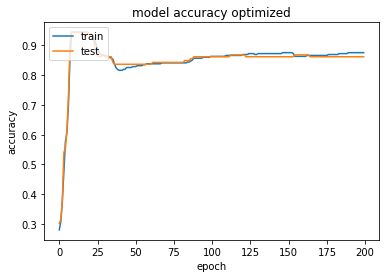

In [23]:
# summarize history for accuracy
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('model accuracy optimized')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


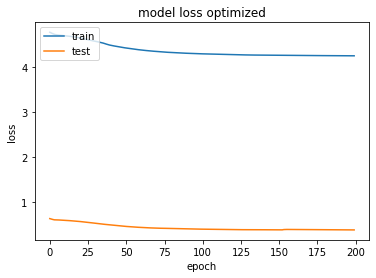

In [24]:
# summarize history for loss
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('model loss optimized')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Visualize the Neural Network
from ann_visualizer.visualize import ann_viz
ann_viz(nn,view=True, filename="NN_predictEF_optimized", title= "Optimized EF Neural Network")

### 6. Model Accuracy

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5/5 - 0s - loss: 0.5940 - accuracy: 0.8875 - 182ms/epoch - 36ms/step
Loss: 0.5939754247665405, Accuracy: 0.887499988079071
